In [5]:
import boto3
from botocore.exceptions import ClientError


bucket = 'sleep-quality-forecast-bucket'
key = 'SLEEP_RECORD.csv'
s3 = boto3.client('s3')


In [9]:
import pandas as pd
from io import StringIO

# Load csv
obj = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(obj['Body'])
df.head()

,PATIENT_ID,SORT_KEY,USAGE_HOURS,FG_SERIAL_NO,SESSION_DATE,MODE,SLEEP_SCORE,AHI_SCORE,LEAK_SCORE,MASK_SCORE,...,RECORD_MD5,RECORD_ARCHIVE_IND,SOURCE_SYSTEM_ID,SOURCE,IS_PHI,RECEIVE_TIMESTAMP,HASH_SORT_KEY_EIDD,HASH_PATIENT_ID_EIDD,HASH_SERIAL_NUMBER_EIDD,BACKFILLED
0,00uj29u96glKg7Bhx297,SLEEP_RECORD#2023-12-27,10.580000,23231347531,2023-12-27,AutoSet,100,5,20,5,...,NaN,Y,13,MDS,NaN,NaN,7e4762cd73375e1cf810cf16c21c652979344ea49baab3...,1e8e184ba057b61fc42c0bcc8b4c0fc9910d4f6529d974...,a9bacd67d5282f0a123db889a2847442041bc74fd1a127...,NaN
1,00uj29u96glKg7Bhx297,SLEEP_RECORD#2025-06-29,8.016667,23231347531,2025-06-29,AutoSet,100,5,20,5,...,NaN,N,13,MDS,NaN,2025-06-30 14:31:13,62a160908c35d96b09411dc897b3316beff8baa328f420...,1e8e184ba057b61fc42c0bcc8b4c0fc9910d4f6529d974...,a9bacd67d5282f0a123db889a2847442041bc74fd1a127...,NaN
2,00uj29u96glKg7Bhx297,SLEEP_RECORD#2024-11-22,10.950000,23231347531,2024-11-22,AutoSet,100,5,20,5,...,NaN,N,13,MDS,NaN,NaN,4c3b9d4c0adf9f752821f5c2be0b8f7bb04d0c87788c26...,1e8e184ba057b61fc42c0bcc8b4c0fc9910d4f6529d974...,a9bacd67d5282f0a123db889a2847442041bc74fd1a127...,NaN
3,00uj29u96glKg7Bhx297,SLEEP_RECORD#2023-05-20,3.930000,23231347531,2023-05-20,AutoSet,60,5,16,0,...,NaN,Y,13,NaN,NaN,NaN,4b7b6661e16d9d23798044512bb46929d0420551d64d54...,1e8e184ba057b61fc42c0bcc8b4c0fc9910d4f6529d974...,a9bacd67d5282f0a123db889a2847442041bc74fd1a127...,NaN
4,00uj29u96glKg7Bhx297,SLEEP_RECORD#2024-04-06,11.670000,23231347531,2024-04-06,AutoSet,100,5,20,5,...,NaN,Y,13,MDS,NaN,NaN,e0fc769118209a3596af04a0ae2dae74714b233cc4d94b...,1e8e184ba057b61fc42c0bcc8b4c0fc9910d4f6529d974...,a9bacd67d5282f0a123db889a2847442041bc74fd1a127...,NaN


In [13]:
# Check missing values
print(df.isna().sum())

# Drop or fill missing rows if small
df = df.dropna(subset=['SLEEP_SCORE', 'USAGE_HOURS'])

# Remove duplicate entries if any
df = df.drop_duplicates()

# Convert date columns
df['SESSION_DATE'] = pd.to_datetime(df['SESSION_DATE'])

SESSION_DATE           0
SLEEP_SCORE            0
USAGE_HOURS            0
AHI_SCORE              0
LEAK_SCORE             0
MASK_SCORE             0
LEAK_50_PERCENTILE    22
LEAK_70_PERCENTILE    22
LEAK_95_PERCENTILE    22
dtype: int64


In [18]:
# Select relevant columns
cols = ['SESSION_DATE', 'SLEEP_SCORE', 'USAGE_HOURS', 'AHI_SCORE', 
        'MASK_SCORE', 'LEAK_50_PERCENTILE', 'LEAK_70_PERCENTILE', 'LEAK_95_PERCENTILE']
df = df[cols].copy()

# Optional: sort by date
df = df.sort_values('SESSION_DATE')


In [19]:
# Example: Day of week, rolling averages, usage change
df['day_of_week'] = df['SESSION_DATE'].dt.day_name()
df['usage_rolling_3d'] = df['USAGE_HOURS'].rolling(window=3, min_periods=1).mean()
df['sleep_rolling_3d'] = df['SLEEP_SCORE'].rolling(window=3, min_periods=1).mean()

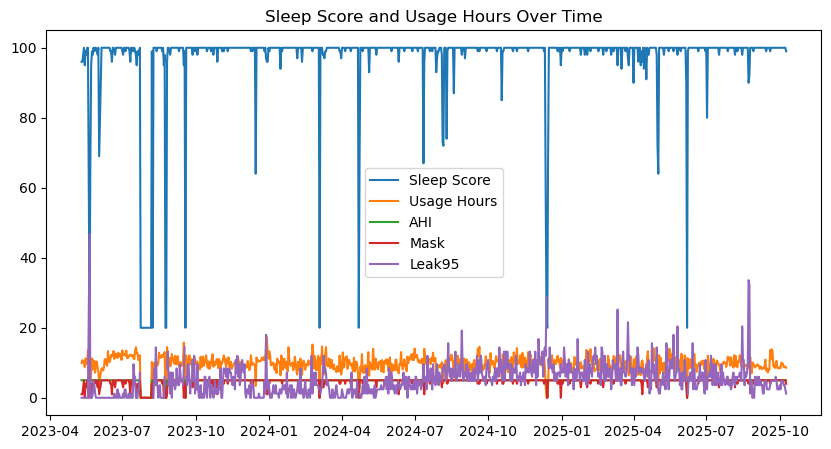

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df['SESSION_DATE'], df['SLEEP_SCORE'], label='Sleep Score')
plt.plot(df['SESSION_DATE'], df['USAGE_HOURS'], label='Usage Hours')
plt.plot(df['SESSION_DATE'], df['AHI_SCORE'], label='AHI')
plt.plot(df['SESSION_DATE'], df['MASK_SCORE'], label='Mask')
plt.plot(df['SESSION_DATE'], df['LEAK_95_PERCENTILE'], label='Leak95')
plt.legend()
plt.title('Sleep Score and Usage Hours Over Time')
plt.show()